Optimal Value Function:
[[0.08272295 0.21005244 0.39161477 0.55987511]
 [0.21005244 0.         0.53273773 0.75179567]
 [0.39161477 0.53273773 0.75616959 0.97332912]
 [0.55987511 0.75179567 0.97332912 0.        ]]

Optimal Policy (epsilon-greedy):
[[[0.025 0.025 0.025 0.925]
  [0.025 0.025 0.025 0.925]
  [0.025 0.025 0.025 0.925]
  [0.025 0.925 0.025 0.025]]

 [[0.025 0.925 0.025 0.025]
  [0.    0.    0.    0.   ]
  [0.025 0.925 0.025 0.025]
  [0.025 0.925 0.025 0.025]]

 [[0.025 0.925 0.025 0.025]
  [0.025 0.025 0.025 0.925]
  [0.025 0.925 0.025 0.025]
  [0.025 0.925 0.025 0.025]]

 [[0.025 0.025 0.025 0.925]
  [0.025 0.025 0.025 0.925]
  [0.025 0.025 0.025 0.925]
  [0.    0.    0.    0.   ]]]


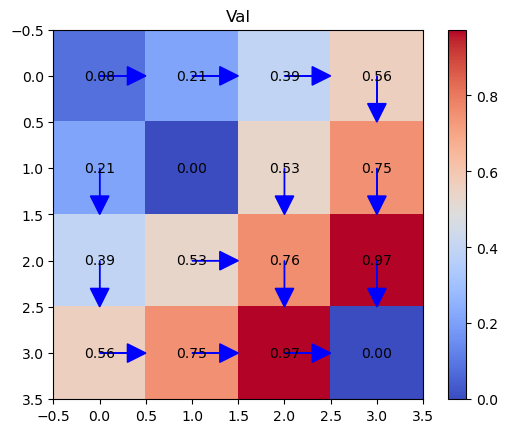

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
from utils import *

class UpdatedGridMDP:
    def __init__(self, grid_size: Tuple[int, int], goal_state: Tuple[int, int], pit_state: Tuple[int, int], gamma: float = 0.9):
        """
        Initialize the gridworld MDP.
        
        Args:
        - grid_size: Size of the grid (rows, columns).
        - goal_state: The goal state where the agent gets a positive reward.
        - pit_state: The state where the agent gets a negative reward (penalty).
        - gamma: Discount factor for future rewards.
        """
        self.grid_size = grid_size
        self.goal_state = goal_state
        self.pit_state = pit_state
        self.actions = ['up', 'down', 'left', 'right']  # Set of possible actions
        self.gamma = gamma
        
        # Define rewards for all states
        self.rewards = np.full(grid_size, -0.1)  # Step penalty for each move
        self.rewards[goal_state] = 1  # Reward for reaching the goal
        self.rewards[pit_state] = -1  # Penalty for falling into a pit
        
        # Initialize the policy randomly (equal probability for each action)
        self.policy = np.ones((grid_size[0], grid_size[1], len(self.actions))) / len(self.actions)

    def get_next_state(self, state: Tuple[int, int], action: str) -> Tuple[int, int]:
        """
        Given a state and an action, return the next state.

        Args:
        - state: Current state (row, col).
        - action: Action taken ('up', 'down', 'left', 'right').

        Returns:
        - Tuple[int, int]: The next state after applying the action.
        """
        row, col = state
        if action == 'up':
            return max(0, row - 1), col
        elif action == 'down':
            return min(self.grid_size[0] - 1, row + 1), col
        elif action == 'left':
            return row, max(0, col - 1)
        elif action == 'right':
            return row, min(self.grid_size[1] - 1, col + 1)

    def get_reward(self, state: Tuple[int, int]) -> float:
        """
        Returns the reward for a given state.
        
        Args:
        - state: The current state.

        Returns:
        - float: The reward value for the state.
        """
        return self.rewards[state]

    def is_terminal(self, state: Tuple[int, int]) -> bool:
        """
        Check if a state is terminal (goal or pit).
        
        Args:
        - state: The current state.
        
        Returns:
        - bool: True if the state is terminal, False otherwise.
        """
        return state == self.goal_state or state == self.pit_state


def policy_iteration(env: UpdatedGridMDP, epsilon: float, theta: float = 0.01, max_iterations: int = 100):
    """
    Perform epsilon-greedy policy iteration.

    This function encapsulates both the policy evaluation and policy improvement processes.
    
    Args:
    - env: The Gridworld MDP environment.
    - epsilon: The exploration rate for epsilon-greedy policy improvement.
    - theta: The convergence threshold for policy evaluation.
    - max_iterations: Maximum number of iterations for evaluation.
    
    Returns:
    - np.ndarray: The optimal value function.
    - np.ndarray: The optimal policy.
    """
    policy = np.ones((env.grid_size[0], env.grid_size[1], len(env.actions))) / len(env.actions)  # Random initial policy
    V = np.zeros(env.grid_size)  # Initialize value function to zero

    def evaluate_policy(policy: np.ndarray) -> np.ndarray:
        """
        Perform policy evaluation.
        
        Args:
        - policy: The current policy being evaluated.
        
        Returns:
        - np.ndarray: The updated value function after policy evaluation.
        """
        V = np.zeros(env.grid_size)
        
        for _ in range(max_iterations):
            delta = 0.0
            for row in range(env.grid_size[0]):
                for col in range(env.grid_size[1]):
                    state = (row, col)
                    if env.is_terminal(state):
                        continue
                    
                    v = V[state]  # Current value
                    
                    # Update the state value based on the current policy
                    new_value = 0.0
                    for action_idx, action_prob in enumerate(policy[state]):
                        action = env.actions[action_idx]
                        next_state = env.get_next_state(state, action)
                        reward = env.get_reward(next_state)
                        new_value += action_prob * (reward + env.gamma * V[next_state])
                    
                    V[state] = new_value
                    delta = max(delta, abs(v - V[state]))  # Calculate change in value
                
            # Stop if the value function has converged
            if delta < theta:
                break
        
        return V

    def improve_policy(V: np.ndarray) -> np.ndarray:
        """
        Perform epsilon-greedy policy improvement.
        
        Args:
        - V: The current value function used to improve the policy.
        
        Returns:
        - np.ndarray: The updated epsilon-greedy policy.
        """
        new_policy = np.zeros_like(policy)
        
        # Iterate over all states in the grid
        for row in range(env.grid_size[0]):
            for col in range(env.grid_size[1]):
                state = (row, col)
                if env.is_terminal(state):
                    continue  # Skip terminal states

                # Calculate action values for each action
                action_values = []
                for action_idx, action in enumerate(env.actions):
                    next_state = env.get_next_state(state, action)
                    reward = env.get_reward(next_state)
                    action_value = reward + env.gamma * V[next_state]
                    action_values.append(action_value)

                # Choose the best action (greedy action)
                best_action_idx = np.argmax(action_values)
                
                # Apply epsilon-greedy policy: random action with probability epsilon
                for action_idx in range(len(env.actions)):
                    if action_idx == best_action_idx:
                        new_policy[row, col, action_idx] = 1 - epsilon + (epsilon / len(env.actions))
                    else:
                        new_policy[row, col, action_idx] = epsilon / len(env.actions)
        
        return new_policy

    # Policy Iteration Loop
    while True:
        # Policy Evaluation
        V = evaluate_policy(policy)
        
        # Policy Improvement
        new_policy = improve_policy(V)
        
        # Check if policy has changed (if not, we have found the optimal policy)
        if np.array_equal(policy, new_policy):
            break
        policy = new_policy
    
    return V, policy


# Example of usage
grid_size = (4, 4)  # Define a 4x4 grid
goal_state = (3, 3)  # Goal at the bottom-right corner
pit_state = (1, 1)  # Pit at position (1, 1)

# Create the environment
env = UpdatedGridMDP(grid_size, goal_state, pit_state)

# Define epsilon for epsilon-greedy exploration
epsilon = 0.1

# Run epsilon-greedy policy iteration
optimal_value_function, optimal_policy = policy_iteration(env, epsilon)

# Output the final value function and policy
print("Optimal Value Function:")
print(optimal_value_function)
print("\nOptimal Policy (epsilon-greedy):")
print(optimal_policy)

visualize_values(optimal_value_function, "Val", optimal_policy)

Optimal Value Function:
[[0.85035027 0.89198355 1.1394869  1.18953196]
 [0.89198355 0.         0.99167353 1.19579763]
 [1.1394869  0.99167353 1.18003935 1.21848758]
 [1.18953196 1.19579763 1.21848758 0.        ]]

Optimal Policy (epsilon-greedy):
[[[0.1   0.1   0.1   0.925]
  [0.1   0.1   0.1   0.925]
  [0.1   0.1   0.1   0.925]
  [0.1   0.925 0.1   0.1  ]]

 [[0.1   0.925 0.1   0.1  ]
  [0.    0.    0.    0.   ]
  [0.1   0.1   0.1   0.925]
  [0.1   0.925 0.1   0.1  ]]

 [[0.1   0.925 0.1   0.1  ]
  [0.1   0.925 0.1   0.1  ]
  [0.1   0.925 0.1   0.1  ]
  [0.1   0.925 0.1   0.1  ]]

 [[0.1   0.1   0.1   0.925]
  [0.1   0.1   0.1   0.925]
  [0.1   0.1   0.1   0.925]
  [0.    0.    0.    0.   ]]]


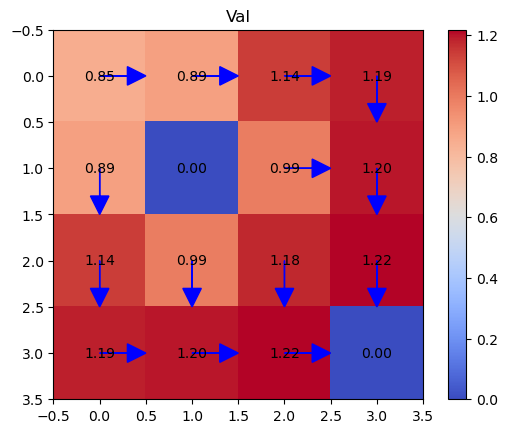

In [7]:
def policy_iteration_epsilon_greedy(env: UpdatedGridMDP, epsilon: float, theta:float = 0.01, max_iterations:int=100)->np.ndarray:
    """
    Perform epsilon-greedy policy iteration.

    This function encapsulates both the policy evaluation and policy improvement processes.
    
    Args:
    - env: The Gridworld MDP environment.
    - epsilon: The exploration rate for epsilon-greedy policy improvement.
    - theta: The convergence threshold for policy evaluation.
    - max_iterations: Maximum number of iterations for evaluation.
    
    Returns:
    - np.ndarray: The optimal value function.
    - np.ndarray: The optimal policy.
    """
    
    # init random policy
    policy = np.ones((env.grid_size[0], env.grid_size[1], len(env.actions)))/ len(env.actions)
    # init value functions 0s
    V = np.zeros(env.grid_size)
    
    # policy eval function
    def evaluate_policy(policy: np.ndarray)->np.ndarray:
        """
        Args:
        - policy: The current policy being evaluated.
        
        Returns:
        - np.ndarray: The updated value function after policy evaluation.
        """
        V = np.zeros(env.grid_size)
        for _ in range(max_iterations):
            delta = 0.0
            for row in range(env.grid_size[0]):
                for col in range(env.grid_size[1]):
                    state = (row, col)
                    if env.is_terminal(state): continue  # Skip terminal states
                    # current value
                    v = V[state]
                    # update the current state value based on the current policy
                    new_value = 0.0
                    
                    for action_idx, action_prob in enumerate(policy[state]):
                        action = env.actions[action_idx]
                        next_state = env.get_next_state(state, action)
                        reward = env.get_reward(next_state)
                        # compute new state value
                        new_value += action_prob * (reward + env.gamma * V[next_state])
                    
                    V[state] = new_value
                    delta = max(delta, abs(v-V[state]))

            # break if the changes are greater than theta
            if delta < theta: break
    
        return V


    def improve_policy(V:np.ndarray)->np.ndarray:
        """
        Args:
        - V: The current value function used to improve the policy.
        
        Returns:
        - np.ndarray: The updated epsilon-greedy policy.
        """
        
        new_policy = np.zeros_like(policy)
        for row in range(env.grid_size[0]):
            for col in range(env.grid_size[1]):
                state = (row, col)
                if env.is_terminal(state): continue  # Skip terminal states
                
                action_values = []
                for action_idx, action in enumerate(env.actions):
                    next_state = env.get_next_state(state, action)
                    reward = env.get_reward(next_state)
                    action_value = reward + env.gamma * V[next_state]
                    action_values.append(action_value)
                
                # pick the best action based on the action value
                best_action_idx = np.argmax(action_values)
                
                # apply (update) epsilon-greedy policy: random action with random policy 
                for action_idx in range(len(env.actions)):
                    if action_idx == best_action_idx:
                        new_policy[row, col, best_action_idx] = 1-epsilon + (epsilon / len(env.actions))
                    else:
                        new_policy[row, col, action_idx] = epsilon
    
        return new_policy
    
    # policy iterations
    while True:
        V = evaluate_policy(policy)
        updated_policy = improve_policy(V)
        # check if the policy has changed.
        if np.array_equal(policy, updated_policy): break
        policy = updated_policy
    
    return V, policy



# Example of usage
grid_size = (4, 4)  # Define a 4x4 grid
goal_state = (3, 3)  # Goal at the bottom-right corner
pit_state = (1, 1)  # Pit at position (1, 1)

# Create the environment
env = UpdatedGridMDP(grid_size, goal_state, pit_state)

# Define epsilon for epsilon-greedy exploration
epsilon = 0.1

# Run epsilon-greedy policy iteration
optimal_value_function, optimal_policy = policy_iteration_epsilon_greedy(env, epsilon)

# Output the final value function and policy
print("Optimal Value Function:")
print(optimal_value_function)
print("\nOptimal Policy (epsilon-greedy):")
print(optimal_policy)

visualize_values(optimal_value_function, "Val", optimal_policy)